In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf


In [10]:
# Load dataset
data_train = np.load('./drive/MyDrive/train_dataset3.npz')
CLASS_LABELS = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion',
                'Fighting', 'Normal', 'RoadAccidents', 'Robbery', 'Shooting',
                'Shoplifting', 'Stealing', 'Vandalism']
class_names = data_train['class_names']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_train['X'], data_train['y'], test_size=0.2, random_state=42)

print(f"Loaded dataset:")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Loaded dataset:
X_train shape: (52800, 64, 64, 3), X_test shape: (13200, 64, 64, 3)


In [5]:
def plot_sample(X, y, index):
    plt.figure(figsize=(3, 2))
    plt.imshow(X[index] )  # Multiply back by 255 for visualization
    plt.xlabel(class_names[y[index]])



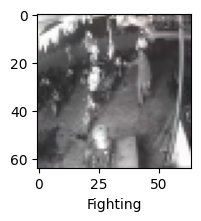

In [6]:
# Example usage of plot_sample
plot_sample(X_train, y_train, 5)

In [11]:
# Define CNN model
cnn = models.Sequential([
    Input(shape=(64, 64, 3)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(14, activation='softmax')
])

# Compile model
learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)

cnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Preprocess function for datasets
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image, label

# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# # Compute class weights
# class_weights = compute_class_weight(
#     'balanced', classes=np.unique(y_train), y=y_train
# )
# class_weight_dict = dict(enumerate(class_weights))
# print(f"Class Weights: {class_weight_dict}")

# Define checkpoint to save the full model
checkpoint_path = "./drive/MyDrive/cnn_model_checkpoint.keras"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Save the full model
    verbose=1
)



In [16]:
# Compute class weights for all classes present in the dataset
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(
    'balanced',
    classes=unique_classes,  # Ensure all classes are included
    y=y_train
)

# Convert to dictionary format
class_weight_dict = dict(enumerate(class_weights))

# Ensure class_weight_dict has entries for all classes (0 to 13)
for class_idx in range(len(class_names)):
    if class_idx not in class_weight_dict:
        class_weight_dict[class_idx] = 1.0  # Assign a neutral weight if missing

print(f"Updated Class Weights: {class_weight_dict}")

Updated Class Weights: {0: 1.6908986101325818, 1: 1.6707274625826662, 2: 1.695840693753011, 3: 1.6831904109152347, 4: 1.7079640292424145, 5: 1.6755521706016756, 6: 1.690194948621915, 7: 0.1694001694001694, 8: 1.6965490649701176, 9: 1.6652474217049862, 10: 1.7094017094017093, 11: 1.6951329138307436, 12: 1.7115627735096761, 13: 1.0}


In [17]:
# Train the model
history = cnn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    class_weight=class_weight_dict,  # Pass class weights
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/50
1642/1650 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1605 - loss: 2.3057
Epoch 1: val_loss improved from inf to 2.02038, saving model to ./drive/MyDrive/cnn_model_checkpoint.keras
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.1608 - loss: 2.3048 - val_accuracy: 0.2731 - val_loss: 2.0204
Epoch 2/50
1642/1650 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3976 - loss: 1.7483
Epoch 2: val_loss improved from 2.02038 to 1.77264, saving model to ./drive/MyDrive/cnn_model_checkpoint.keras
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3979 - loss: 1.7478 - val_accuracy: 0.4033 - val_loss: 1.7726
Epoch 3/50
1647/1650 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5412 - loss: 1.4096
Epoch 3: val_loss improved from 1.77264 to 1.41284, saving model to ./drive/MyDrive/cnn_model_checkpoint.keras
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5413 - loss: 1.4095 - val_accuracy: 0.5808 - val_loss: 1.4128
Epoch 4/50
1648/1650 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

In [19]:
model_h5_path = "./drive/MyDrive/cnn_model_2.keras"
cnn.save(model_h5_path)  # Save in HDF5 format
print(f"\nModel saved in HDF5 format at: {model_h5_path}")


Model saved in HDF5 format at: ./drive/MyDrive/cnn_model_2.keras


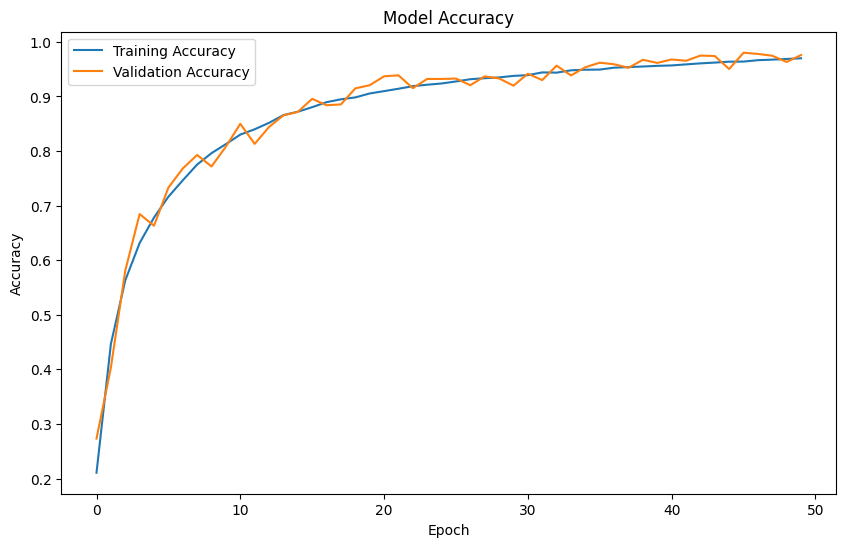

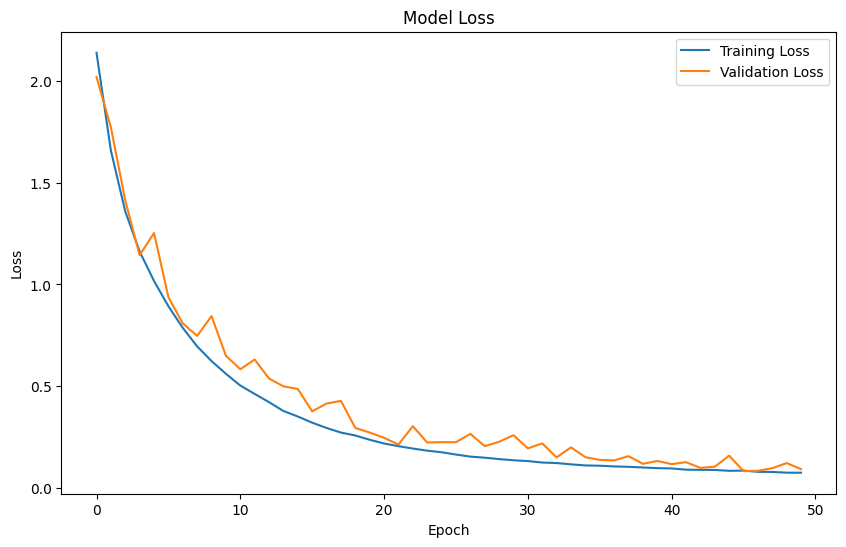

In [20]:
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [21]:
cnn.evaluate(X_test,y_test)

413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0938 - loss: 5499.3193


[5533.13720703125, 0.0903787910938263]

In [22]:
y_pred= cnn.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print("classification_report\n",classification_report(y_test,y_pred_classes))
y_pred_classes[:5]

413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
classification_report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       598
           1       0.00      0.00      0.00       569
           2       0.00      0.00      0.00       605
           3       0.00      0.00      0.00       587
           4       0.10      0.02      0.03       622
           5       0.05      0.93      0.10       576
           6       0.12      0.29      0.18       597
           7       0.49      0.06      0.10      6024
           8       0.00      0.00      0.00       606
           9       0.00      0.00      0.00       561
          11       0.00      0.00      0.00       624
          12       0.48      0.17      0.26       604
          13       0.72      0.04      0.07       627

    accuracy                           0.09     13200
   macro avg       0.15      0.12      0.06     13200
weighted avg       0.29      0.09      0.07     13200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[5, 5, 5, 5, 5]

In [23]:
y_test[:5]


array([4, 7, 7, 5, 9], dtype=int32)

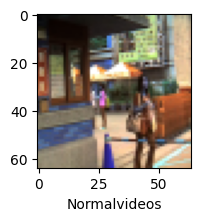

In [26]:
plot_sample(X_test,y_test,1)

In [27]:
class_names[y_pred_classes[1]]

'Explosion'